Remove duplicates and outliers (pCHEMBL <2 OR >12); make sure SMILES are valid

In [11]:
import pandas as pd
from rdkit import Chem
import seaborn as sns


# Load the CSV dataset
file_path = 'TRPM8-homosapien-compounds-activities-processed.csv'
print(f"Loading dataset from {file_path}...")

df = pd.read_csv(file_path)
print(f"Initial dataset contains {df.shape[0]} rows and {df.shape[1]} columns.\n")
print("First few rows of initial dataset:")
print(df.head(), "\n")

# Step 1: Keep only necessary columns (pCHEMBL Value is the -log IC50, the target value)
columns_to_keep = [
    'Molecule ChEMBL ID',
    'Smiles',
    'pChEMBL Value'
]
df = df[columns_to_keep]
print(f"After keeping only necessary columns, dataset contains {df.shape[1]} columns: {columns_to_keep}\n")

# Step 2: Remove duplicates based on 'Molecule ChEMBL ID' and 'Smiles'
print("Checking for duplicates...")
before_duplicates = df.shape[0]
df = df.drop_duplicates(subset=['Molecule ChEMBL ID', 'Smiles'])
after_duplicates = df.shape[0]
print(f"Removed {before_duplicates - after_duplicates} duplicate rows. Remaining rows: {after_duplicates}\n")

# Step 3: Remove rows with empty pChEMBL Value (this is -logIC50)
before_missing = df.shape[0]
df = df.dropna(subset=['pChEMBL Value'])
after_missing = df.shape[0]
print(f"Removed {before_missing - after_missing} rows with missing pChEMBL Value. Remaining rows: {after_missing}\n")


# Step 4: Remove outliers with pChEMBL Value < 2 or > 12
print("Checking for pChEMBL outliers...")
outliers = df[(df['pChEMBL Value'] < 2) | (df['pChEMBL Value'] > 12)]
print(f"Found {outliers.shape[0]} outliers with pChEMBL Value < 2 or > 12:")
print(outliers)

# Remove outliers
before_outliers = df.shape[0]
df = df[(df['pChEMBL Value'] >= 2) & (df['pChEMBL Value'] <= 12)]
after_outliers = df.shape[0]
print(f"Removed {before_outliers - after_outliers} outlier rows. Remaining rows: {after_outliers}\n")

# Step 5: Ensure valid SMILES representation (removing invalid SMILES)
def is_valid_smiles(smiles):
    mol = Chem.MolFromSmiles(smiles)
    return mol is not None

df['valid_smiles'] = df['Smiles'].apply(is_valid_smiles)
df = df[df['valid_smiles']].drop(columns=['valid_smiles'])

print("Validating SMILES strings...")
df['valid_smiles'] = df['Smiles'].apply(is_valid_smiles)
invalid_smiles_count = (~df['valid_smiles']).sum()
print(f"Found {invalid_smiles_count} invalid SMILES. Removing them...\n")
df = df[df['valid_smiles']].drop(columns=['valid_smiles'])

print(f"Final dataset contains {df.shape[0]} rows.\n")
print("First few rows of final cleaned dataset:")
print(df.head(), "\n")


# Save the cleaned file
#output_file = '../processed/TRPM8_cleaned_preprocessed.csv'
#df.to_csv(output_file, index=False)

#print(f"Cleaned file saved as '{output_file}'")


Loading dataset from TRPM8-homosapien-compounds-activities-processed.csv...
Initial dataset contains 654 rows and 25 columns.

First few rows of initial dataset:
  Molecule ChEMBL ID  Molecular Weight  #RO5 Violations  AlogP Compound Key  \
0      CHEMBL3235962            421.42              1.0   5.76           22   
1      CHEMBL3235983            434.36              1.0   5.45           44   
2      CHEMBL1650511            467.41              1.0   7.09            5   
3      CHEMBL2443068            438.83              1.0   5.39           9b   
4      CHEMBL3959823            358.44              0.0   3.86           9n   

                                              Smiles Standard Type  \
0  N#Cc1cccc(NC(=O)N2CCc3ccccc3[C@H]2c2ccc(C(F)(F...          IC50   
1  C[C@H](NC(=O)N1CCc2ccccc2[C@H]1c1ccc(C(F)(F)F)...          IC50   
2  FC(F)(F)c1ccccc1-c1cc(C(F)(F)F)c2[nH]c(C3=NOC4...          IC50   
3  O=C1CC2(CCN(C(=O)Nc3ccc(C(F)(F)F)cc3)CC2)Oc2c(...          IC50   
4  Cc1cccc(CN

pCHEMBL Value (-log IC50) distribution

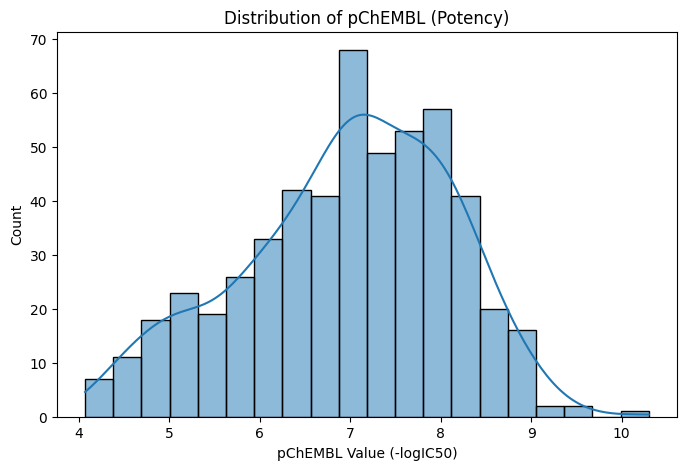

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.histplot(df['pChEMBL Value'], kde=True, bins=20)
plt.title('Distribution of pChEMBL (Potency)')
plt.xlabel('pChEMBL Value (-logIC50)')
plt.show()

Make input files for classification and regression tasks

In [22]:
import pandas as pd

# Load preprocessed dataset
df = pd.read_csv("../processed/TRPM8_cleaned_preprocessed.csv")  

# Step 1: Assign categorical potency class
def assign_potency_class(value):
    if value < 5:
        return "Low potency"
    elif 5 <= value < 7:
        return "Medium potency"
    else:
        return "High potency"

# Apply classification names
df["class_name"] = df["pChEMBL Value"].apply(assign_potency_class)

# Step 2: Map to encoded labels
label_encoding = {"Low potency": 0, "Medium potency": 1, "High potency": 2}
df["class_label"] = df["class_name"].map(label_encoding)

# Save classification CSV
df_class = df[["Molecule ChEMBL ID", "Smiles", "class_label"]]
df_class.to_csv("../processed/TRPM8_graph_classification.csv", index=False)

# Save regression CSV
df_reg = df[["Molecule ChEMBL ID", "Smiles", "pChEMBL Value"]]
df_reg.to_csv("../processed/TRPM8_graph_regression.csv", index=False)

print("✅ Files saved:")
print(" - TRPM8_graph_classification.csv")
print(" - TRPM8_graph_regression.csv")


✅ Files saved:
 - TRPM8_graph_classification.csv
 - TRPM8_graph_regression.csv


Extract partial charges from ORCA outputs and save as JSON file (will be used in feature extraction pipeline)

In [ ]:
import os
import re
import json

# Directory containing ORCA .out files
orca_output_dir = "../initial_data/orca_outputs"
output_data = {}

# Regular expression pattern to extract Mulliken charges
pattern = re.compile(r"^\s*(\d+)\s+\w+\s+:\s+([-+]?\d*\.\d+|\d+)", re.MULTILINE)

# Iterate over all .out files in the directory
for filename in os.listdir(orca_output_dir):
    if filename.endswith(".out"):
        molecule_id = filename.replace(".out", "")
        file_path = os.path.join(orca_output_dir, filename)
        with open(file_path, "r") as file:
            content = file.read()
            if "MULLIKEN ATOMIC CHARGES" in content:
                charges_block = content.split("MULLIKEN ATOMIC CHARGES")[-1]
                charges = [float(match[1]) for match in pattern.findall(charges_block)]
                output_data[molecule_id] = {
                    "mulliken_charges": charges
                }

# Save to JSON file
output_json_path = "../../2_feature_extraction/mulliken_charges.json"
with open(output_json_path, "w") as json_file:
    json.dump(output_data, json_file, indent=2)

output_json_path


'../..//2_feature_extraction/mulliken_charges_2.json'

Plot the distribution of classifications

/var/folders/jj/slvcr9z519n1bkmnjypy4m5c0000gn/T/ipykernel_6944/3499966987.py:15: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(df["classification_label"], discrete=True, shrink=0.8, palette="Set2")


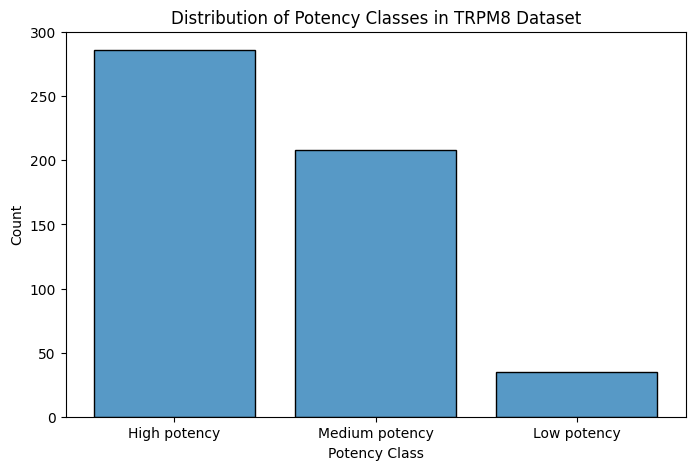

In [23]:
# Define classification labels based on pChEMBL Value (Low, Medium, High Potency)
def assign_potency_class(value):
    if value < 5:
        return "Low potency"
    elif 5 <= value < 7:
        return "Medium potency"
    else:
        return "High potency"

# Apply classification
df["classification_label"] = df["pChEMBL Value"].apply(assign_potency_class)

# Plot the distribution of classifications
plt.figure(figsize=(8, 5))
sns.histplot(df["classification_label"], discrete=True, shrink=0.8, palette="Set2")
plt.title("Distribution of Potency Classes in TRPM8 Dataset")
plt.xlabel("Potency Class")
plt.ylabel("Count")
plt.show()



Distribution of SMILES length 

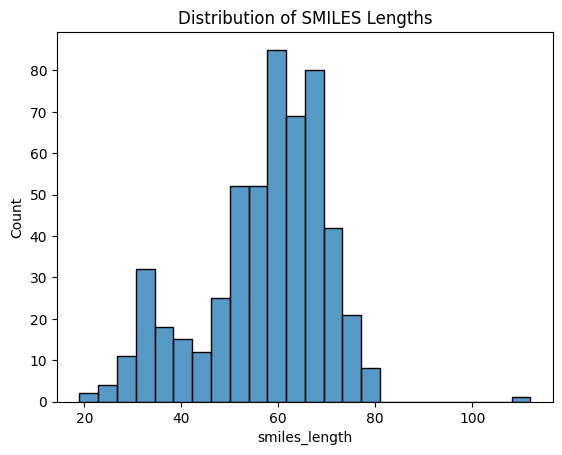

In [4]:
df['smiles_length'] = df['Smiles'].apply(len)
sns.histplot(df['smiles_length'])
plt.title('Distribution of SMILES Lengths')
plt.show()